In [13]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from main import RNNLayer
import ast
import DSA
import copy
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load config

In [14]:
config = load_config("../config.yaml")
taskset = "GoNogo"

In [15]:
def parse_model_info(model_name):
    model_name = model_name.replace(".pth", "")
    model_name = model_name.split("_")
    d_model = int(model_name[1])
    n_layers = int(model_name[2])
    learning_rate = float(model_name[3])
    batch_size = int(model_name[4])
    return d_model, n_layers, learning_rate, batch_size


parse_model_info("mamba_8_1_0.01_16_train.pth")

(8, 1, 0.01, 16)

### Get dissimilarities

#### Computation dynamics

In [16]:
measures = ["cka", "dsa", "procrustes"]
dissimilarities = {measure: [] for measure in measures}

groups = [
    "untrained",
    "master",
    "pretrained_basic_anti_frozen",
    "pretrain_frozen",
    "pretrain_unfrozen",
]


def symmetric(array):
    for i in range(array.shape[0]):
        for j in range(i, array.shape[1]):
            array[j, i] = array[i, j]
    return array


# function to replace all nan which are on diagonal of an array
def replace_nan_diagonal(array):
    for i in range(array.shape[0]):
        if np.isnan(array[i, i]):
            array[i, i] = 0
    return array


def replace_nan_diagonal_list(arrays):
    return [replace_nan_diagonal(arr) for arr in arrays]

# function to remove among list of arrays the ones which have nan values within array
def remove_nan(array):
    return array if not np.isnan(np.sum(array)) else None

def remove_nan_list(lists):
    return [remove_nan(arr) for arr in lists]

In [17]:
path = f"../data/dissimilarities/mamba/{taskset}/"
df = {"d_model":[], "n_layers":[], "learning_rate":[], "batch_size":[], "group1":[], "group2":[],"measure":[], "dissimilarity":[]} 
for measure in measures:
    path_measure = os.path.join(path, measure)
    files = os.listdir(path_measure)
    for file in files:
        file_path = os.path.join(path_measure, file)
        if file_path.endswith(".npz"):
            d_model, n_layers, learning_rate, batch_size = parse_model_info(file)
            with np.load(file_path, allow_pickle=True) as data:
                dissimilarities[measure].append(data["arr_0"])
                for group1 in groups:
                    for group2 in groups:
                        array_dissimilarities = remove_nan(
                            replace_nan_diagonal(data["arr_0"])
                        )
                        if array_dissimilarities is not None:
                            array_dissimilarities = symmetric(array_dissimilarities)
                            df["d_model"].append(d_model)
                            df["n_layers"].append(n_layers)
                            df["learning_rate"].append(learning_rate)
                            df["batch_size"].append(batch_size)
                            df["group1"].append(group1)
                            df["group2"].append(group2)
                            df["measure"].append(measure)
                            df["dissimilarity"].append(array_dissimilarities[groups.index(group1), groups.index(group2)])
df = pd.DataFrame(df)
# dissimilarities["dsa"] = [arr for arr in dissimilarities["dsa"] if arr.shape != ()]
# dissimilarities["cka"] = [arr for arr in dissimilarities["cka"] if arr.shape != ()]
# dissimilarities["procrustes"] = [arr for arr in dissimilarities["procrustes"] if arr.shape != ()]

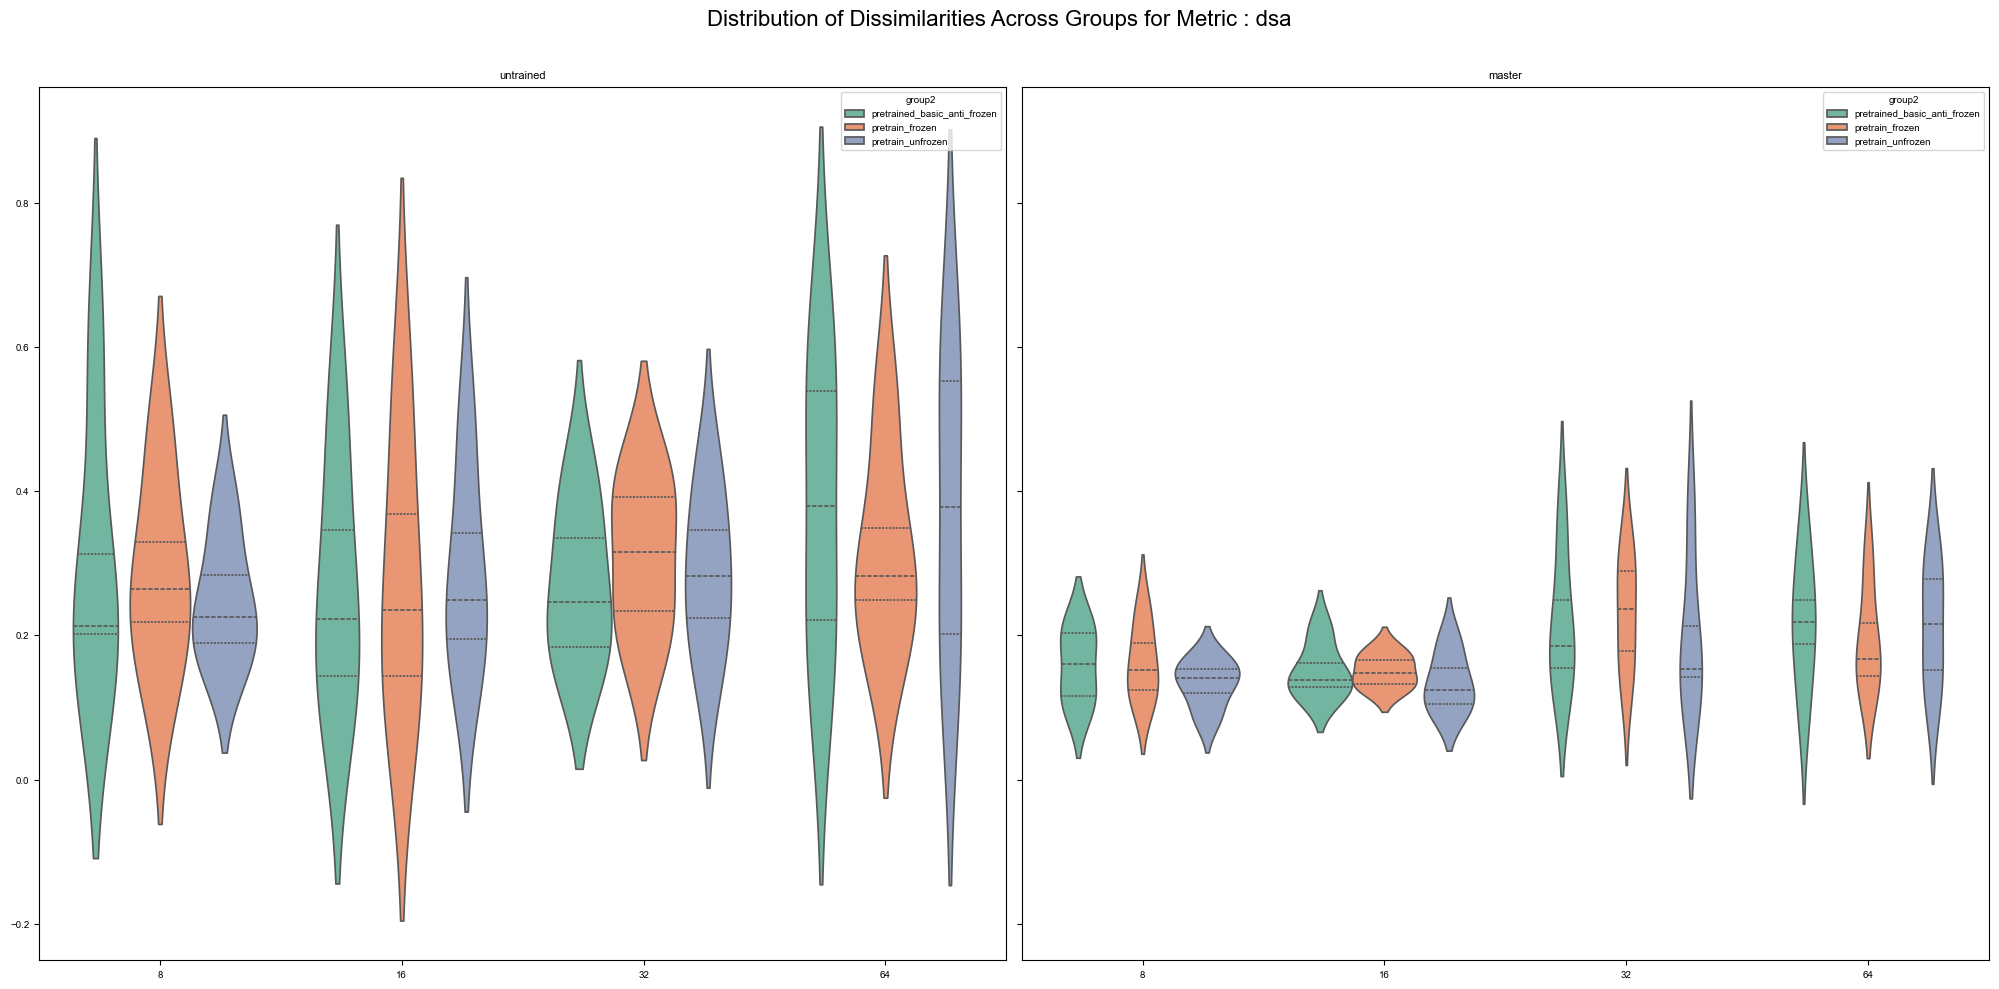

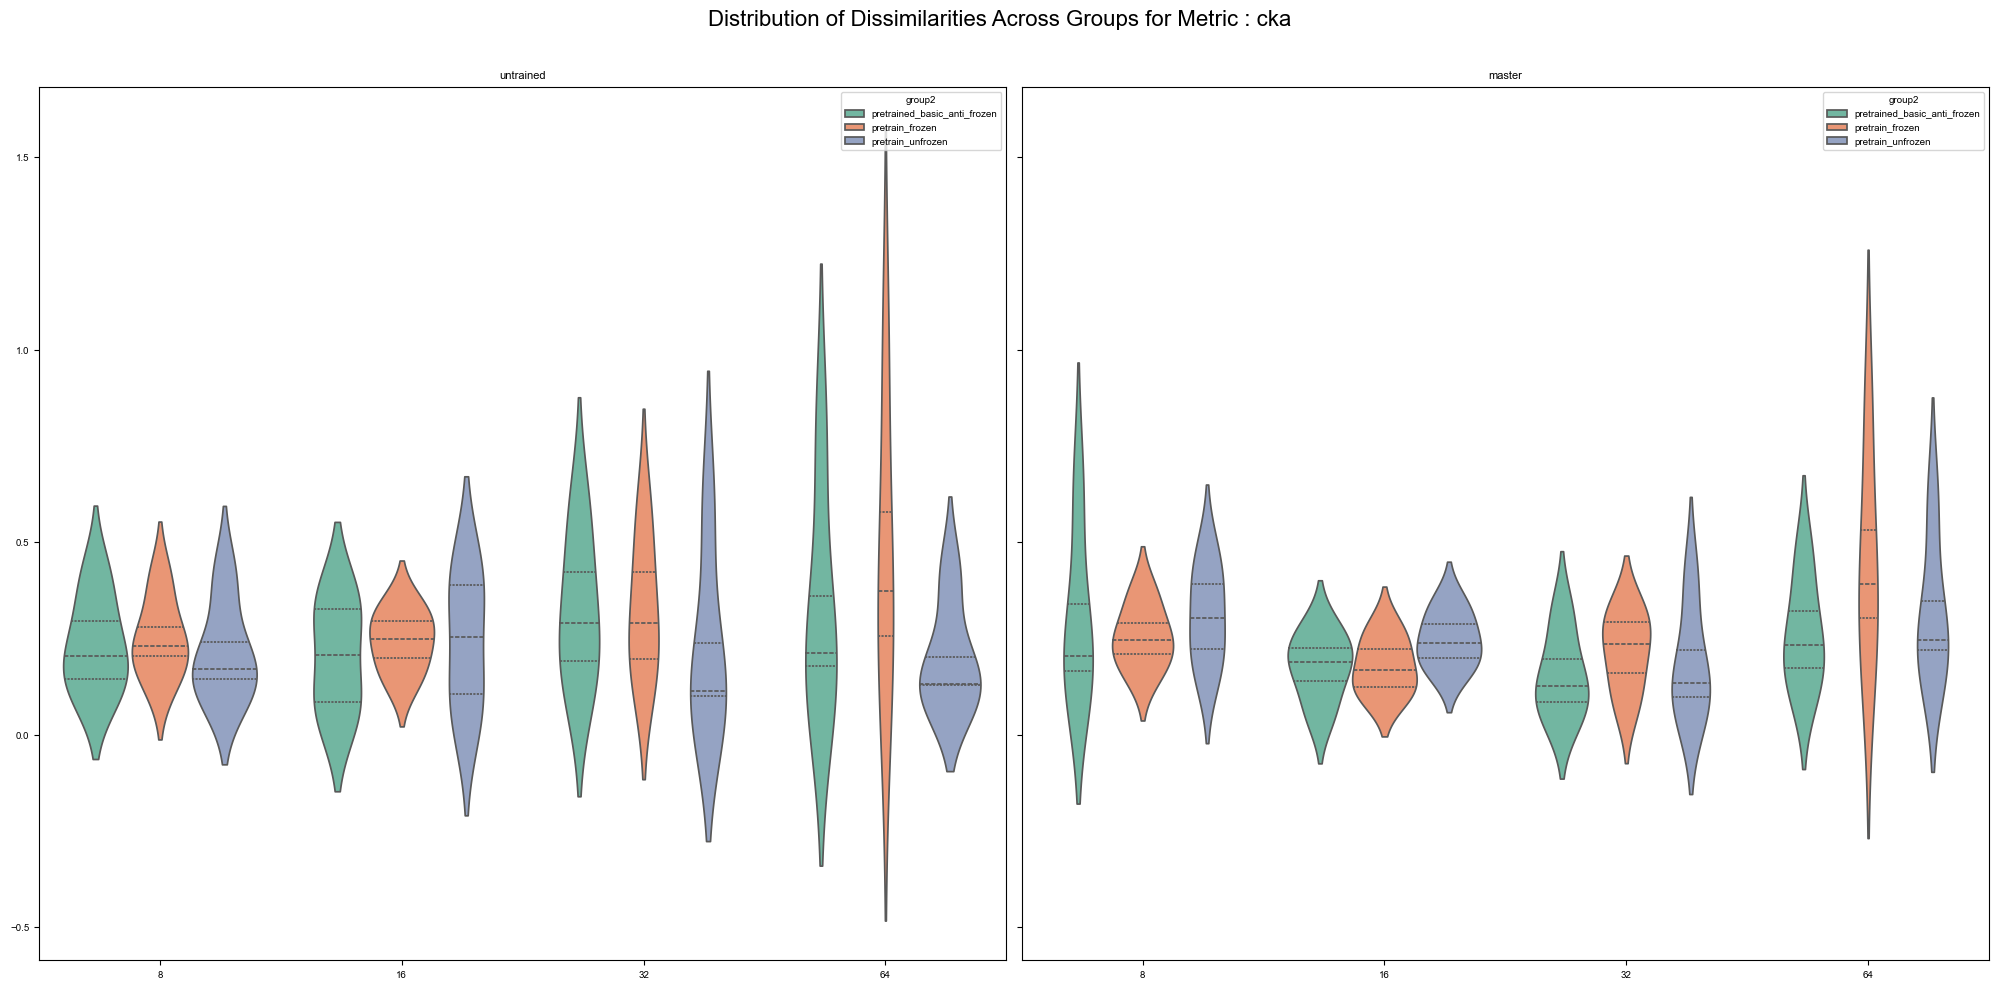

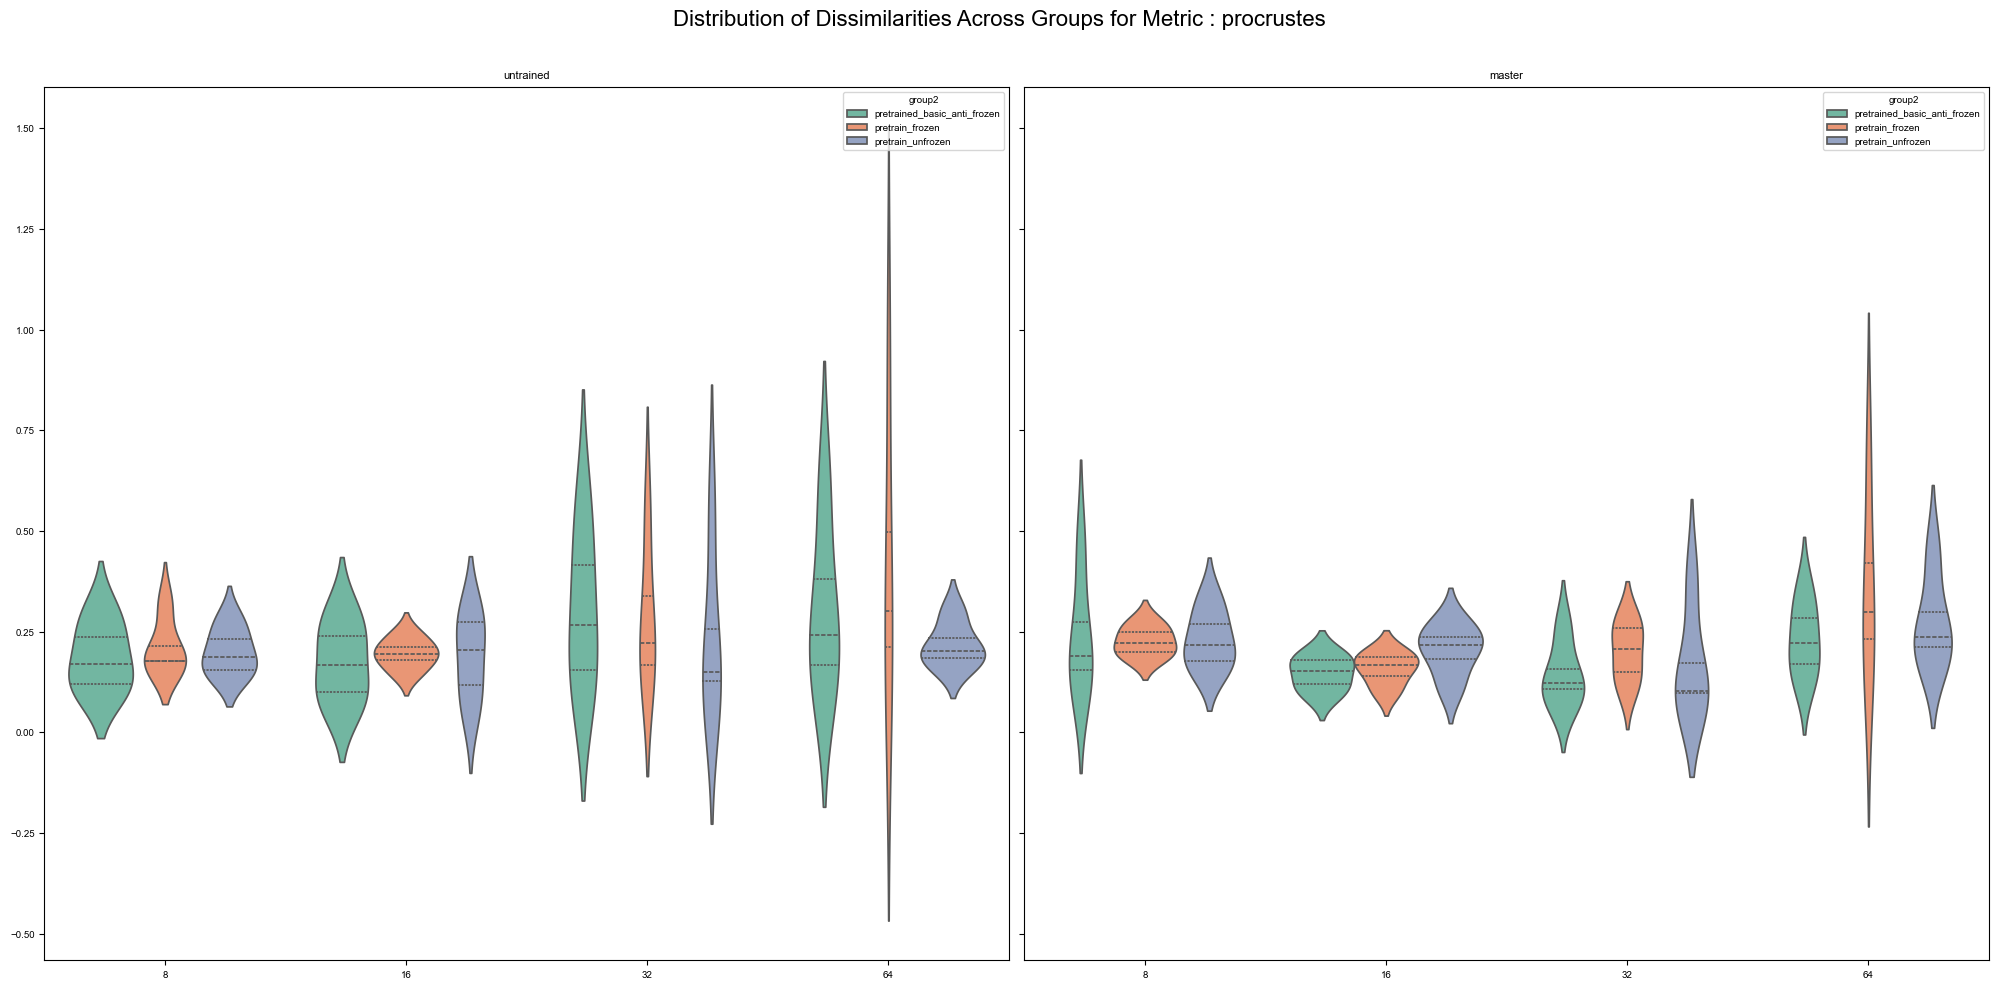

In [18]:
from math import log
groups_base = ["untrained", "master"]
groups_selected = ["pretrained_basic_anti_frozen", "pretrain_frozen", "pretrain_unfrozen"]
df_selected = df[df["group1"].isin(groups_base) & df["group2"].isin(groups_selected)]
for measure in ["dsa", "cka", "procrustes"]:
    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(20, 10), sharex=True, sharey=True
    )

    # Iterate over each group pair
    for group in groups_base:
        ax = axes[groups_base.index(group)]
        # Plot a violin plot for the dissimilarity distribution
        sns.violinplot(
            data=df_selected[
                (df_selected["group1"] == group) &
                (df_selected["measure"] == measure)
            ],
            x="d_model",
            y="dissimilarity",
            hue="group2",
            ax=ax,
            inner="quart",
            palette="Set2",
        )
        ax.set_title(f"{group}", fontsize=8)
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Adjust layout
    plt.suptitle(
        f"Distribution of Dissimilarities Across Groups for Metric : {measure}",
        fontsize=16,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [19]:
# Group by 'group1', 'group2', and 'measure', then calculate median dissimilarities
median_dissimilarities = (
    df.groupby(["group1", "group2", "measure"])["dissimilarity"].median().reset_index()
)

# Pivot the data to prepare it for the heatmap
pivot_table = median_dissimilarities.pivot_table(
    index="group1", columns="group2", values="dissimilarity"
)

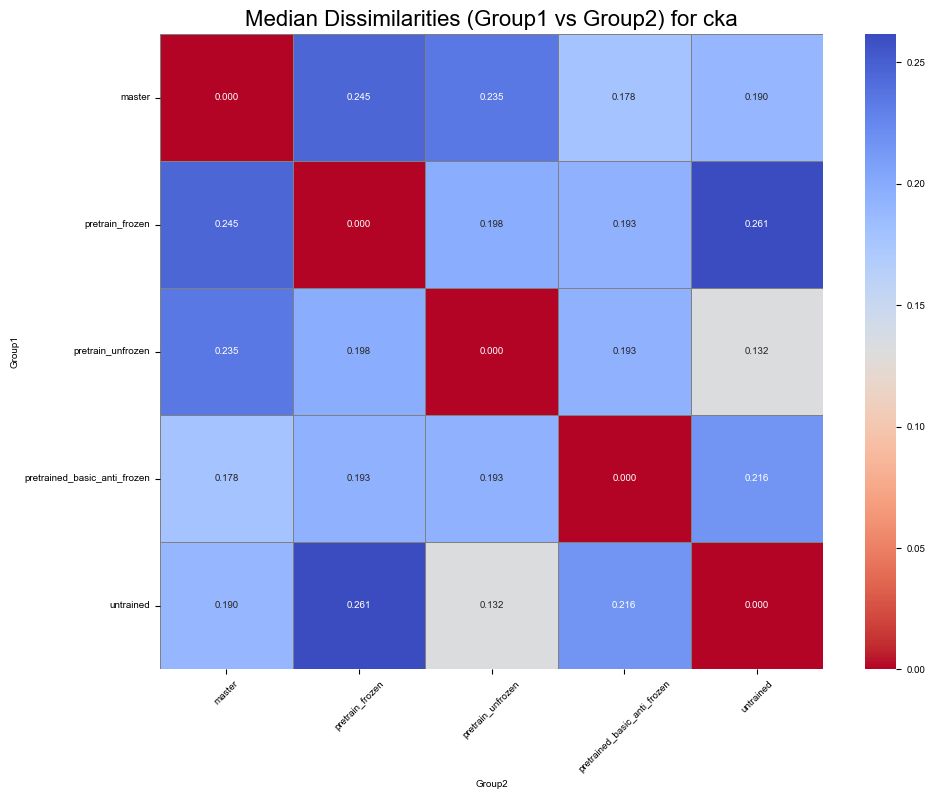

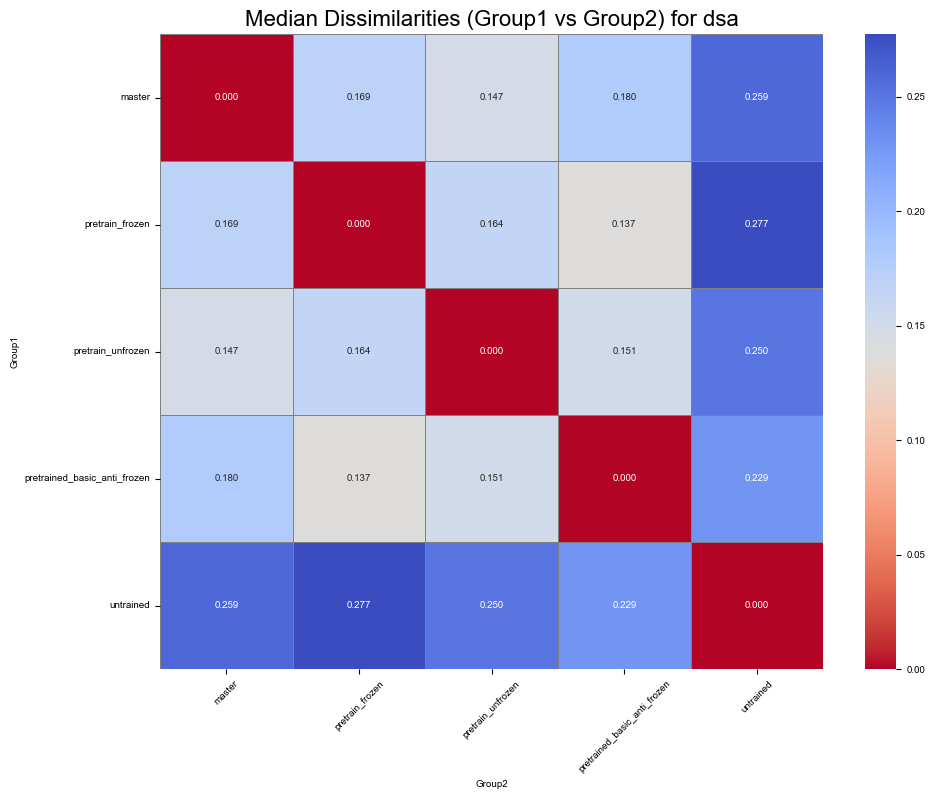

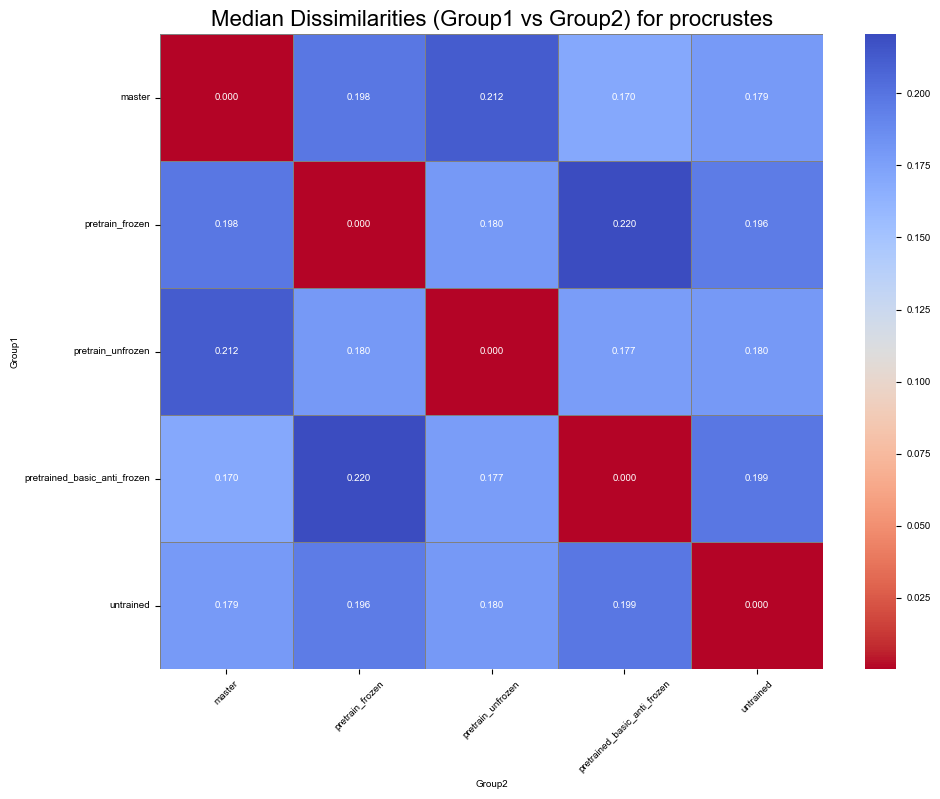

In [20]:
# Unique measures
measures = df["measure"].unique()

# Plot heatmap for each measure
for measure in measures:
    # Filter the pivot table for the specific measure
    measure_pivot = median_dissimilarities[
        median_dissimilarities["measure"] == measure
    ].pivot(index="group1", columns="group2", values="dissimilarity")

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        measure_pivot,
        annot=True,
        fmt=".3f",
        cmap="coolwarm_r",
        cbar=True,
        linewidths=0.5,
        linecolor="gray",
    )
    plt.title(f"Median Dissimilarities (Group1 vs Group2) for {measure}", fontsize=16)
    plt.xlabel("Group2")
    plt.ylabel("Group1")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [21]:
# unique groups :
from asyncio import tasks


groups = list(config[taskset]["groups"].keys())
# generate all possible pairs of groups
pairs = [
    (groups[i], groups[j]) for i in range(len(groups)) for j in range(i, len(groups))
]
# group pairs of groups by how many tasks they share in their training curriculum
group_pairs = {}
for pair in pairs:
    group1, group2 = pair
    group1_tasks = (
        config[taskset]["groups"][group1]["pretrain"]["ruleset"]
        + config[taskset]["groups"][group1]["train"]["ruleset"]
        if config[taskset]["groups"][group1]["train"]["frozen"] == False
        else config[taskset]["groups"][group1]["pretrain"]["ruleset"]
    )
    group2_tasks = (
        config[taskset]["groups"][group2]["pretrain"]["ruleset"]
        + config[taskset]["groups"][group2]["train"]["ruleset"]
        if config[taskset]["groups"][group2]["train"]["frozen"] == False
        else config[taskset]["groups"][group2]["pretrain"]["ruleset"]
    )
    if len(group1_tasks) == 0 and len(group2_tasks) == 0:
        shared_tasks = 100
    elif len(group1_tasks) == 0 or len(group2_tasks) == 0:
        shared_tasks = 0
    else:
        shared_tasks = int(
            100
            * len(set(group1_tasks).intersection(set(group2_tasks)))
            / max(len(group1_tasks), len(group2_tasks))
        )
    try:
        group_pairs[shared_tasks].append(pair)
    except KeyError:
        group_pairs[shared_tasks] = [pair]

In [22]:
dissimilarities_per_shared_task = {"dsa": {perc:[] for perc in group_pairs.keys()}, "cka":  {perc:[] for perc in group_pairs.keys()}, "procrustes":  {perc:[] for perc in group_pairs.keys()}}
for shared_tasks, pairs in group_pairs.items():
    for pair in pairs:
        group1, group2 = pair
        data_pair = df[
            ((df["group1"] == group1) & (df["group2"] == group2))
            # or the opposite
            | ((df["group1"] == group2) & (df["group2"] == group1))
        ]
        # if pair == ("pretrain_frozen", "pretrain_unfrozen"):
        #     print(data_pair)
        for measure in measures:
            data_pair_mesure = data_pair[data_pair["measure"] == measure]["dissimilarity"].tolist()
            dissimilarities_per_shared_task[measure][shared_tasks].extend(
                data_pair_mesure
            )
            if pair == ("pretrain_frozen", "pretrain_unfrozen"):
                print(f"mesure : {measure}")
                print(f"pair data mesure : {data_pair_mesure}")

mesure : cka
pair data mesure : [0.13722194751131955, 0.13722194751131955, 0.17734747066685563, 0.17734747066685563, 0.1481341646417369, 0.1481341646417369, 0.4628193404861394, 0.4628193404861394, 0.1692779203541832, 0.1692779203541832, 0.2182197335975622, 0.2182197335975622, 0.1242979813668742, 0.1242979813668742, 0.29000798869873035, 0.29000798869873035, 0.9704339883855905, 0.9704339883855905, 0.11168126802196299, 0.11168126802196299, 0.2234205562731737, 0.2234205562731737, 0.3749383979130063, 0.3749383979130063, 0.4267164735530471, 0.4267164735530471, 0.17257057437691814, 0.17257057437691814, 0.26044715471882285, 0.26044715471882285, 0.13231541863058527, 0.13231541863058527]
mesure : dsa
pair data mesure : [0.09218594431877136, 0.09218594431877136, 0.11526921391487122, 0.11526921391487122, 0.10374623537063599, 0.10374623537063599, 0.30657193064689636, 0.30657193064689636, 0.16936413943767548, 0.16936413943767548, 0.17012661695480347, 0.17012661695480347, 0.19580940902233124, 0.19580

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/repal-8PB6Q6y1-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/repal-8PB6Q6y1-py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


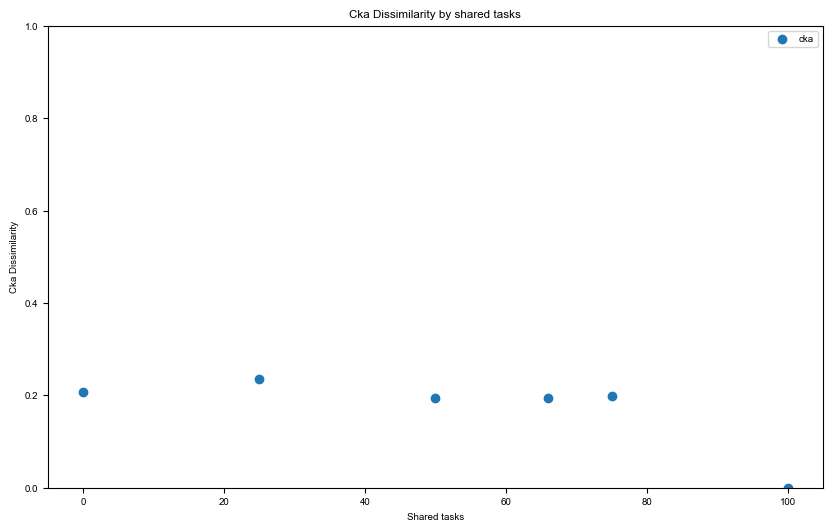

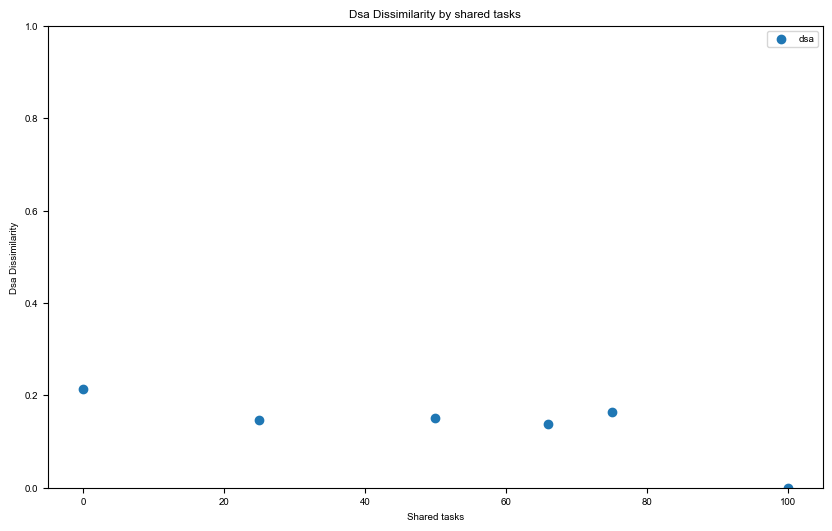

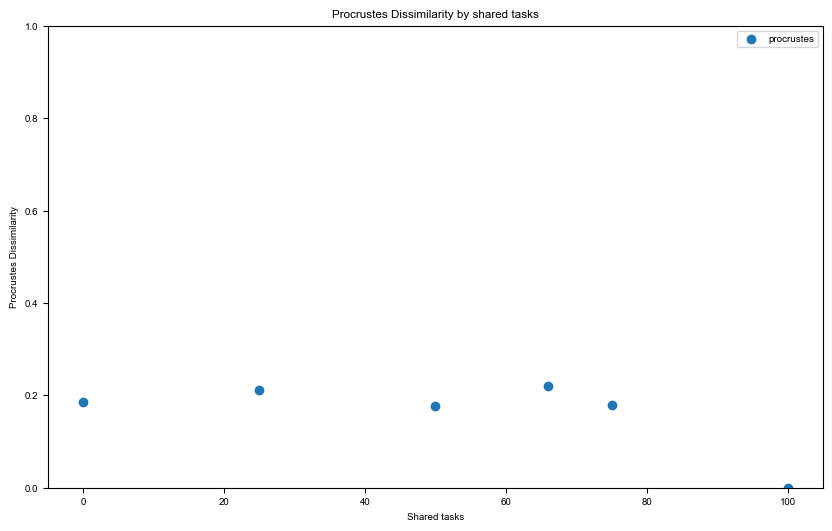

In [23]:
# plot the dissimilarities per shared task by taking median of the dissimilarities for each shared task. shared task as x-axis and dissimilarity as y-axis and do a line plot without errors
for measure in ["cka", "dsa", "procrustes"]:
    dissimilarities_per_shared_task[measure] = {
        k: np.median(v) for k, v in dissimilarities_per_shared_task[measure].items()
    }
    percent_shared_tasks_sorted = sorted(
        list(dissimilarities_per_shared_task[measure].keys())
    )
    dissimilarities = [dissimilarities_per_shared_task[measure][percent] for percent in percent_shared_tasks_sorted]
    plt.figure(figsize=(10, 6))
    plt.scatter(
        percent_shared_tasks_sorted,
        dissimilarities,
        label=measure,
    )
    plt.xlabel("Shared tasks")
    plt.ylim(0, 1)
    plt.ylabel(f"{measure.capitalize()} Dissimilarity")
    plt.title(f"{measure.capitalize()} Dissimilarity by shared tasks")
    plt.legend()
    plt.show()    

#### Learning dynamics

For now, only analysis for pretrain_frozen against pretrain_unfrozen

In [24]:
# take all the folder names under data/dissimilarities_over_learning/{taskset}
groups_training = os.listdir(f"../data/dissimilarities_over_learning/mamba/{taskset}")
groups_training = [group for group in groups_training if group != ".DS_Store"]
dissimilarities_groups = {group: None for group in groups_training}

dissimilarities_groups = {group: None for group in groups_training}
for group_training in groups_training: 
    path = f"../data/dissimilarities_over_learning/mamba/{taskset}/{group_training}"
    measures = ["cka", "dsa", "procrustes", "accuracy_1", "accuracy_2"]
    sampling = [0, 25, 50, 75, 100]
    dissimilarities = {measure: [] for measure in measures}

    for measure in measures:
        path_measure = os.path.join(path, measure)
        files = os.listdir(path_measure)
        for file in files:
            file_path = os.path.join(path_measure, file)
            if file_path.endswith(".npz"):
                with np.load(file_path) as data:
                    dissimilarities[measure].append(data["arr_0"])
    dissimilarities_interpolated = {
        measure: {group: [] for group in range(len(sampling) - 1)} for measure in measures
    }
    for measure in measures:
        for dissimilarity in dissimilarities[measure]:
            if dissimilarity.shape[0] > 4:
                for i in range(len(sampling) - 1):
                    index_start = int(sampling[i] / 100 * (dissimilarity.shape[0]))
                    index_end = int(sampling[i + 1] / 100 * (dissimilarity.shape[0]))
                    dissimilarities_interpolated[measure][i].append(
                        np.median(dissimilarity[index_start:index_end])
                    )
    for measure in measures:
        for group in range(len(sampling) - 1):
            dissimilarities_interpolated[measure][group] = np.mean(
                dissimilarities_interpolated[measure][group]
            )
    dissimilarities_groups[group_training] = dissimilarities_interpolated

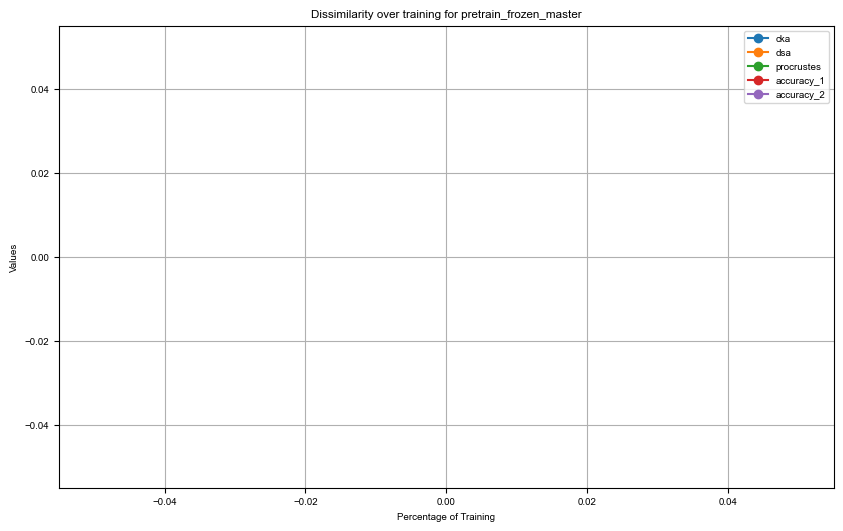

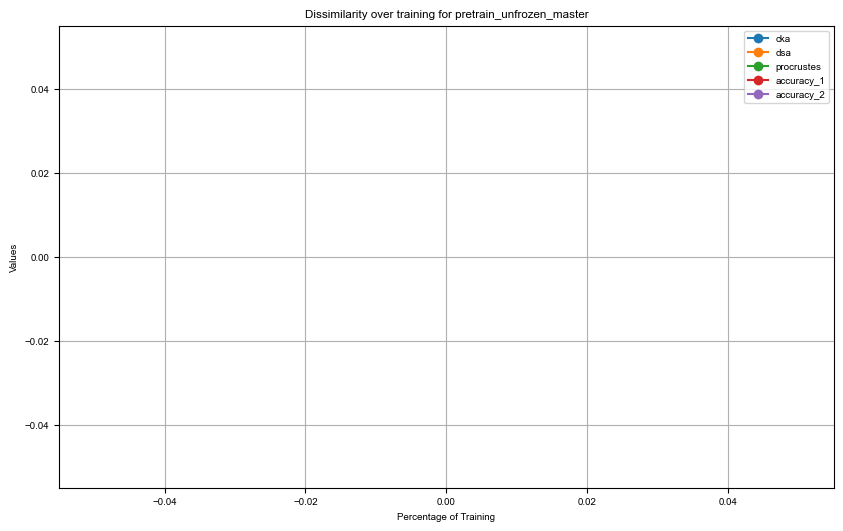

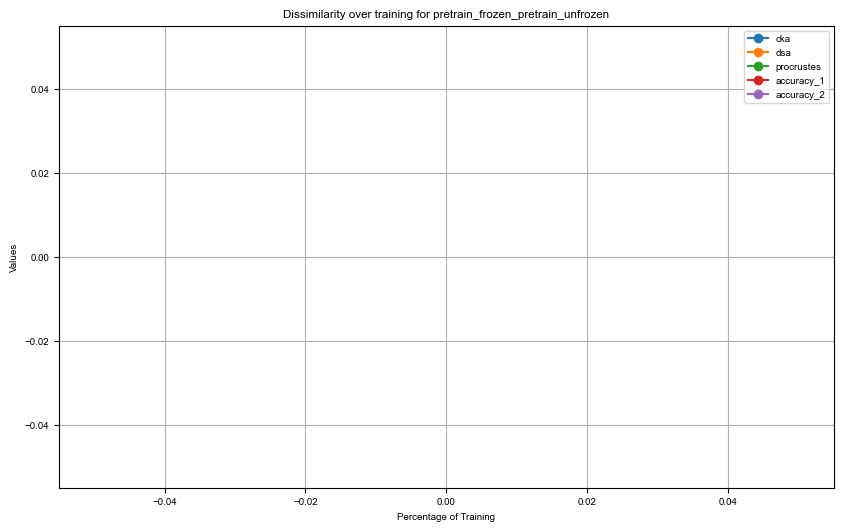

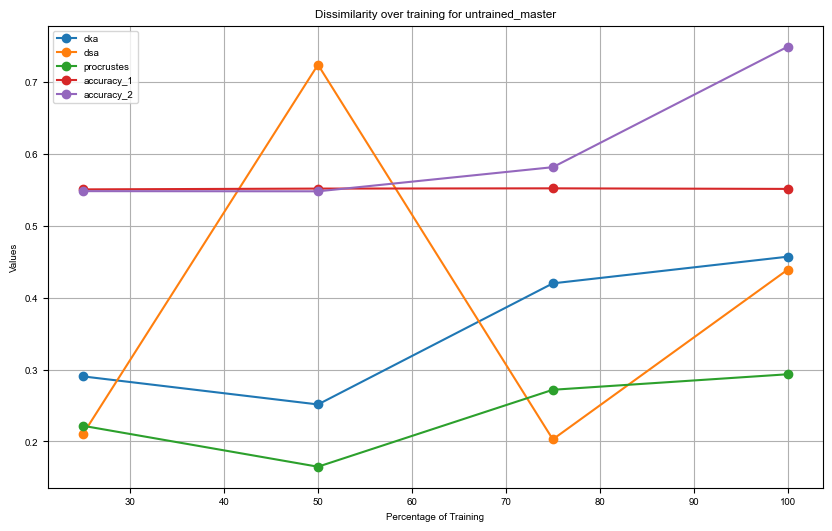

In [25]:
for group_training in groups_training:
    dissimilarities_interpolated = dissimilarities_groups[group_training]
    # X-axis values
    x_values = [25, 50, 75, 100]

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot each key with a different color
    for key, values in dissimilarities_interpolated.items():
        plt.plot(x_values, list(values.values()), marker="o", label=key)

    # Adding labels and title
    plt.xlabel("Percentage of Training")
    plt.ylabel("Values")
    plt.title("Dissimilarity over training for {}".format(group_training))
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()

### Dissimilarity within group 

In [30]:
path = f"../data/dissimilarities_within_learning/mamba/{taskset}/pretrain_frozen"
measures = ['cka','dsa','procrustes']
dissimilarities = {measure:[] for measure in measures}


for measure in measures:
    if measure == "dsa":
        path_measure = os.path.join(path, measure)
        files = os.listdir(path_measure)
        for file in files:
            file_path = os.path.join(path_measure, file)
            if file_path.endswith(".npz"):
                with np.load(file_path) as data:
                    print(measure)
                    print(data["arr_0"])
                    dissimilarities[measure].append(data["arr_0"])
# Function to check if any non-diagonal element is less than the threshold
def has_small_non_diagonal_elements(arr, threshold=1e-10):
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if i != j and arr[i, j] < threshold:
                return True
    return False
for (
    measure,
    value,
) in dissimilarities.items():  # Stack the arrays along a new axis (axis 0)
    dissimilarities[measure] = [
        arr for arr in value if not has_small_non_diagonal_elements(arr)
    ]
for (
    measure,
    value,
) in dissimilarities.items():  # Stack the arrays along a new axis (axis 0)
    dissimilarities[measure] = np.median(np.stack(value, axis=0), axis=0)

dsa
[[8.52079269e-316 0.00000000e+000 8.49133879e-268 1.99255405e-311]
 [1.39067116e-309 2.44140514e-315 2.38694104e-253 1.98201440e-311]
 [4.63927641e-321 8.91504415e-307 8.90097454e-307 3.38629052e-258]
 [2.75696430e-292 1.23516411e-322 4.23849153e-307 0.00000000e+000]]
dsa
[[9.52434100e-316 0.00000000e+000 8.49133879e-268 1.99255405e-311]
 [1.39067116e-309 2.44140514e-315 2.38694104e-253 1.98201440e-311]
 [4.63927641e-321 8.91504415e-307 8.90097454e-307 3.38629052e-258]
 [2.75696430e-292 1.23516411e-322 4.23849153e-307 0.00000000e+000]]
dsa
[[9.38669258e-316 0.00000000e+000 8.49133879e-268 1.99255405e-311]
 [1.39067116e-309 2.44140514e-315 2.38694104e-253 1.98201440e-311]
 [4.63927641e-321 8.91504415e-307 8.90097454e-307 3.38629052e-258]
 [2.75696430e-292 1.23516411e-322 4.23849153e-307 0.00000000e+000]]
dsa
[[8.50221755e-316 0.00000000e+000 8.49133879e-268 1.99255405e-311]
 [1.39067116e-309 2.44140514e-315 2.38694104e-253 1.98201440e-311]
 [4.63927641e-321 8.91504415e-307 8.9009745

ValueError: need at least one array to stack

In [ ]:
# Percentage labels to use instead of indices
percent_labels = ["25%", "50%", "75%", "100%"]

for measure, value in dissimilarities.items():
    # Create the heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(value, annot=True, cmap="Reds", cbar=True, square=True, fmt=".2f")

    # Set the percentage labels on the x and y axes
    ax.set_xticklabels(percent_labels)
    ax.set_yticklabels(percent_labels)

    # Set axis labels
    ax.set_xlabel("Training Progress")
    ax.set_ylabel("Training Progress")

    # Set the title
    plt.title(f"{measure.capitalize()} Dissimilarity Over Training")

    # Show the plot
    plt.show()